In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

# Events Table

In [2]:
events = pd.read_csv('events.csv', parse_dates=True)
events['event_timestamp'] = pd.to_datetime(events['event_timestamp'])

In [3]:
events.head()

,user_id,user_session_id,event_timestamp,app,time_seconds
0,02fd5305cce536a1940aea0818ba7a3d,6690452e89aa62cdfa818d1f469aaf37,2015-03-22 00:08:12,build,67
1,955ef0ba3e7de00197f2ab6828cb4d05,af2d613e4e5695fd4d8610a0086de760,2015-03-22 20:56:29,build,277
2,955ef0ba3e7de00197f2ab6828cb4d05,af2d613e4e5695fd4d8610a0086de760,2015-03-22 21:15:33,build,779
3,3768b95029f051316727e5413362dcff,7af8b316d551662e89ef0afbedd06be8,2015-03-22 02:17:00,build,145
4,3768b95029f051316727e5413362dcff,7af8b316d551662e89ef0afbedd06be8,2015-03-22 03:26:03,draw,319


In [4]:
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27726 entries, 0 to 27725
Data columns (total 5 columns):
user_id            27726 non-null object
user_session_id    27726 non-null object
event_timestamp    27726 non-null datetime64[ns]
app                27726 non-null object
time_seconds       27726 non-null int64
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 1.1+ MB


# Users Table

In [5]:
users = pd.read_csv('users.csv', parse_dates=True)
users['install_date'] = pd.to_datetime(users['install_date'])

In [6]:
users.head()

,user_id,install_date,app_version
0,000a0efdaf94f2a5a09ab0d03f92f5bf,2014-12-25,v1
1,0020cb805d63f036ad2c22dd8e76e368,2016-01-16,Unknown
2,002a9119a4b3dfb05e0159eee40576b6,2015-12-29,v2
3,0038c5018fb1c0c9d0dea9181a5a0834,2015-06-06,v2
4,00448cf7dd8ad9e8a57fdcfa262a4438,2015-12-22,v2


In [7]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
user_id         3900 non-null object
install_date    3900 non-null datetime64[ns]
app_version     3900 non-null object
dtypes: datetime64[ns](1), object(2)
memory usage: 91.5+ KB


# Number of Users

In [8]:
# Converting seconds into minutes
events['time_min'] = events['time_seconds'] / 60
events.drop('time_seconds', axis=1, inplace=True)

In [9]:
events_2 = pd.merge(events, users, how='left', on='user_id')

In [10]:
# User_id's and versions that they use.
events_2.head()

,user_id,user_session_id,event_timestamp,app,time_min,install_date,app_version
0,02fd5305cce536a1940aea0818ba7a3d,6690452e89aa62cdfa818d1f469aaf37,2015-03-22 00:08:12,build,1.116667,2015-03-21,v1
1,955ef0ba3e7de00197f2ab6828cb4d05,af2d613e4e5695fd4d8610a0086de760,2015-03-22 20:56:29,build,4.616667,2015-01-26,v1
2,955ef0ba3e7de00197f2ab6828cb4d05,af2d613e4e5695fd4d8610a0086de760,2015-03-22 21:15:33,build,12.983333,2015-01-26,v1
3,3768b95029f051316727e5413362dcff,7af8b316d551662e89ef0afbedd06be8,2015-03-22 02:17:00,build,2.416667,2015-03-22,v1
4,3768b95029f051316727e5413362dcff,7af8b316d551662e89ef0afbedd06be8,2015-03-22 03:26:03,draw,5.316667,2015-03-22,v1


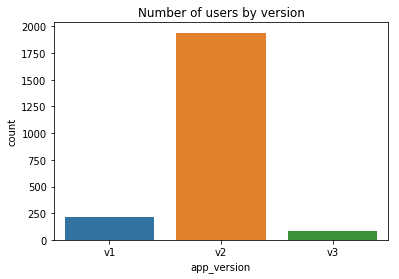

In [11]:
# Histogram of user counts per version
events_with_unique_users = events_2.drop_duplicates(subset='user_id', keep='first')
sns.countplot(x='app_version', data=events_with_unique_users)
plt.title('Number of users by version')
plt.savefig('01.png')
plt.show()

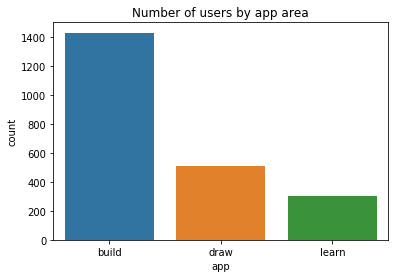

In [12]:
sns.countplot(x='app', data=events_with_unique_users)
plt.title('Number of users by app area')
plt.savefig('02.png')
plt.show()

In [13]:
# Total number of users
monthly_users = events_with_unique_users.resample('M', on='event_timestamp')['user_id'].count()

In [14]:
monthly_users = pd.DataFrame(monthly_users.cumsum()).reset_index()
monthly_users['months'] = monthly_users.event_timestamp.apply(lambda x: x.strftime('%Y-%m'))
monthly_users = monthly_users.rename(columns={'user_id' : 'total_users'})

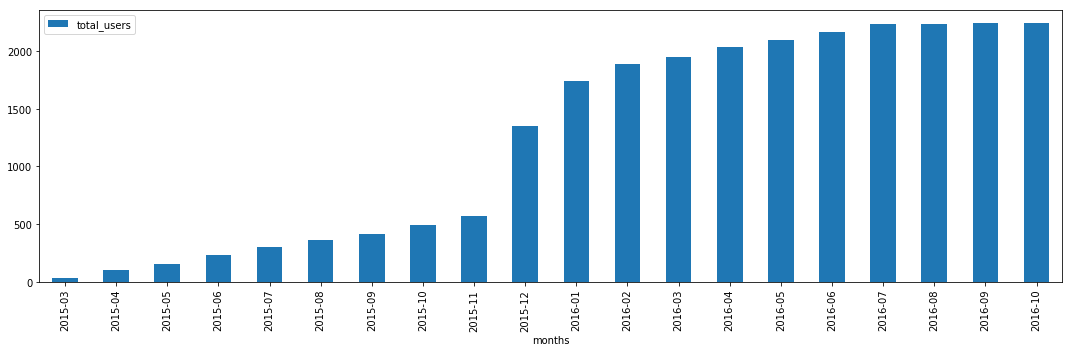

In [15]:
monthly_users.plot(x='months',y='total_users',figsize=(15,5),kind='bar')
plt.tight_layout()
plt.savefig('03.png')
plt.show()

# Monthly Active Users

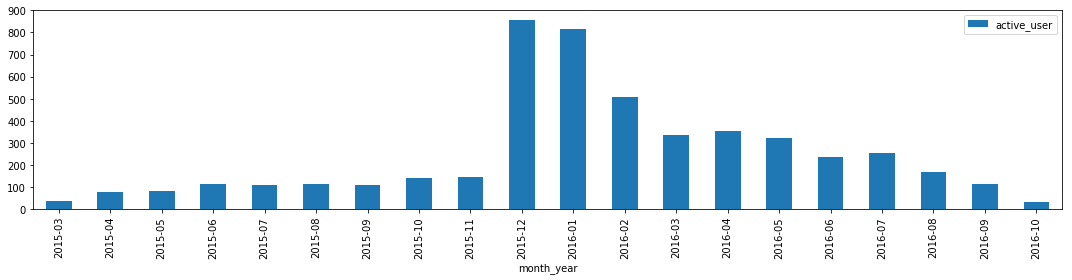

In [16]:
events_3 = events_2.resample('M',on='event_timestamp').agg({'user_id': pd.Series.nunique})
events_3 = events_3.reset_index()
events_3['month_year'] = events_3['event_timestamp'].apply(lambda x:x.strftime('%Y-%m'))
events_3.drop('event_timestamp', axis=1, inplace=True)
events_3.rename(columns={'user_id':'active_user'}, inplace=True)
events_3.head()
events_3.plot(x='month_year', y='active_user',figsize=(15,4), kind='bar')
plt.tight_layout()
plt.savefig('04.png')
plt.show()

In [17]:
# Active users by versions
events_4 = events_2.copy()
events_4['date'] = (pd.to_datetime(events_4['event_timestamp'])).apply(lambda x: x.strftime('%Y-%m'))
active_users_versions = events_4.groupby(['app_version','date']).agg({'user_id': pd.Series.nunique})
active_users_versions = active_users_versions.rename(columns={'user_id' : 'total_active_users'})

In [18]:
active_users_versions.head()

total_active_users
app_version date                       
v1          2015-03                  39
            2015-04                  79
            2015-05                  55
            2015-06                  36
            2015-07                  31

In [19]:
active_users_versions_2 = active_users_versions.unstack(level=0)

In [20]:
active_users_versions_2.head()

total_active_users          
app_version                 v1    v2  v3
date                                    
2015-03                   39.0   NaN NaN
2015-04                   79.0   NaN NaN
2015-05                   55.0  28.0 NaN
2015-06                   36.0  78.0 NaN
2015-07                   31.0  77.0 NaN

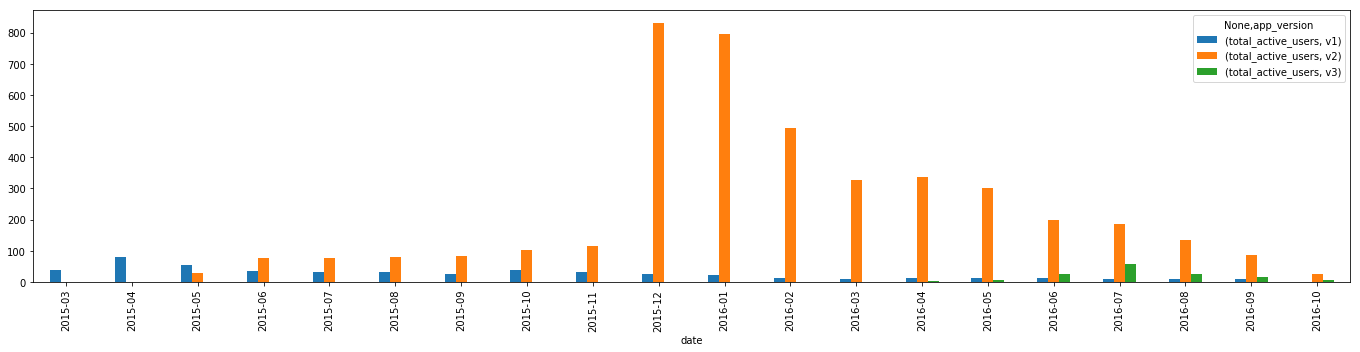

In [21]:
active_users_versions_2.plot(figsize=(19,5), kind='bar')
plt.tight_layout()
plt.savefig('05.png')
plt.show()

# Install Numbers

In [22]:
version_dummies = pd.get_dummies(users['app_version'])
version_counts = pd.concat([users, version_dummies],axis=1)
version_counts.head(4)

,user_id,install_date,app_version,Unknown,v1,v2,v3
0,000a0efdaf94f2a5a09ab0d03f92f5bf,2014-12-25,v1,0,1,0,0
1,0020cb805d63f036ad2c22dd8e76e368,2016-01-16,Unknown,1,0,0,0
2,002a9119a4b3dfb05e0159eee40576b6,2015-12-29,v2,0,0,1,0
3,0038c5018fb1c0c9d0dea9181a5a0834,2015-06-06,v2,0,0,1,0


In [23]:
install_counts = version_counts.groupby(['install_date']).agg({'Unknown' : 'sum', 'v1' : 'sum', 'v2' : 'sum', 'v3' : 'sum'})
install_counts['total_install'] = install_counts.apply(lambda row: row.Unknown + row.v1 + row.v2 + row.v3, axis=1)
install_counts.sample(4)

,Unknown,v1,v2,v3,total_install
install_date,,,,,
2016-05-10,0,0,3.0,0,3.0
2016-02-18,1,0,6.0,0,7.0
2016-07-27,0,0,0.0,1,1.0
2016-01-14,0,0,3.0,0,3.0


In [24]:
install_counts = install_counts.reset_index()
monthly_install = install_counts.resample('M', on='install_date').sum()
monthly_install = monthly_install.reset_index()
monthly_install['install_date'] = monthly_install['install_date'].apply(lambda x: x.strftime('%Y-%m'))
monthly_install.head()

,install_date,Unknown,v1,v2,v3,total_install
0,2014-12,4.0,496.0,0.0,0.0,500.0
1,2015-01,3.0,197.0,0.0,0.0,200.0
2,2015-02,0.0,100.0,0.0,0.0,100.0
3,2015-03,1.0,99.0,0.0,0.0,100.0
4,2015-04,2.0,98.0,0.0,0.0,100.0


In [25]:
monthly_install_cum = monthly_install[['install_date','total_install']]
monthly_install_cum = monthly_install_cum.set_index('install_date')

In [26]:
monthly_install_cum = monthly_install_cum.cumsum()

In [27]:
monthly_install_cum = monthly_install_cum.reset_index()
monthly_install_cum.head()

,install_date,total_install
0,2014-12,500.0
1,2015-01,700.0
2,2015-02,800.0
3,2015-03,900.0
4,2015-04,1000.0


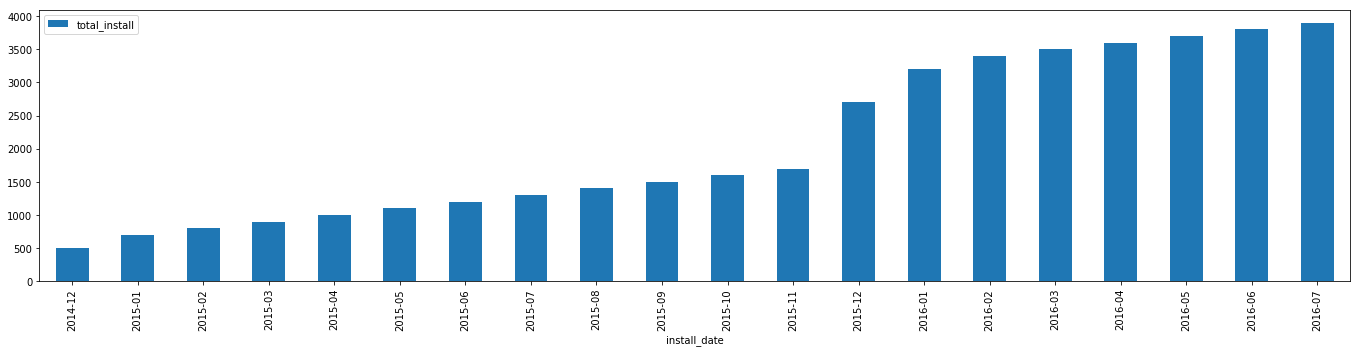

In [28]:
monthly_install_cum.plot('install_date','total_install', figsize=(19,5), kind='bar' )
plt.tight_layout()
plt.savefig('06.png')
plt.show()

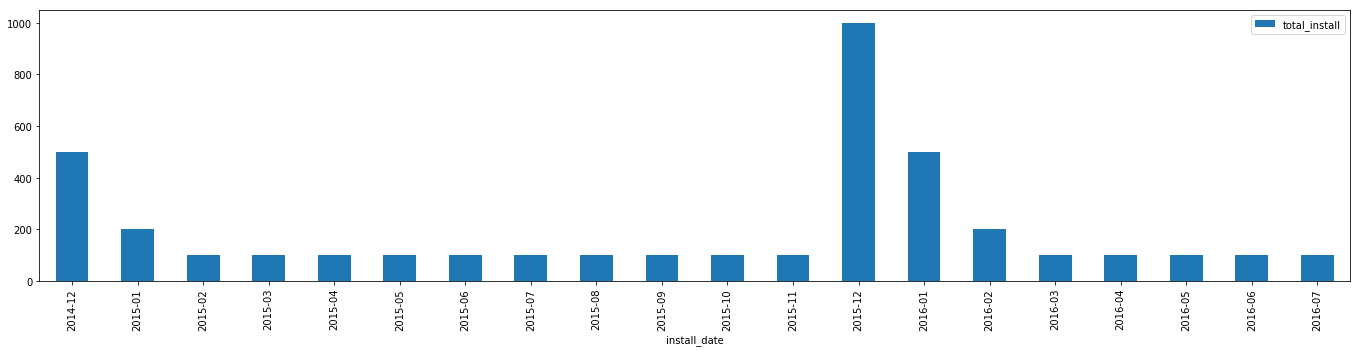

In [29]:
monthly_install.plot('install_date','total_install', figsize=(19,5), kind='bar')
plt.tight_layout()
plt.savefig('07.png')
plt.show()

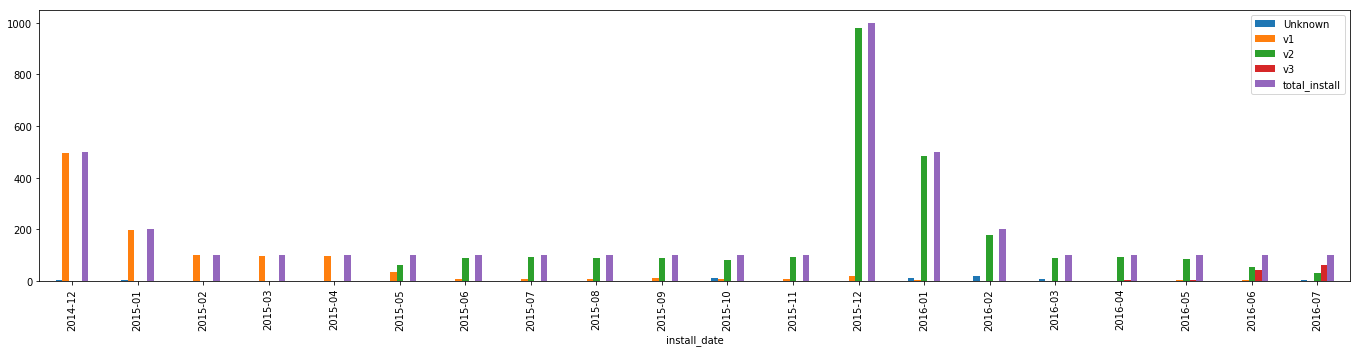

In [30]:
monthly_install.plot('install_date',['Unknown','v1','v2','v3','total_install'], figsize=(19,5), kind='bar')
plt.tight_layout()
plt.savefig('08.png')
plt.show()

# Cohort Analysis for Retention

In [31]:
events_5 = events_2.copy()

In [32]:
# I will take the first event date as the first actions of users
events_5['event_period'] = events_5.event_timestamp.apply(lambda x: x.strftime('%Y-%m'))
events_5.set_index('user_id', inplace=True)
events_5['cohort_group'] = events_5.groupby(level=0)['event_timestamp'].min().apply(lambda x: x.strftime('%Y-%m'))
events_5.reset_index(inplace=True)
events_5.sample(3)

,user_id,user_session_id,event_timestamp,app,time_min,install_date,app_version,event_period,cohort_group
8573,a05f785dc6aa73acd6f7e450e08152da,4fb1be14f5c4aaaf48a2e4048d42fcbb,2015-12-31 19:06:06,build,19.933333,2015-12-31,v2,2015-12,2015-12
2577,9246531b801de242bc837ae3985f6048,4f6ec0362f57415724f61e451478e657,2015-10-12 23:24:23,build,2.033333,2015-09-19,v2,2015-10,2015-09
23813,6fd9c8eb8a16f615eca66fda8810bd75,d44b531b5d795eaab6bf1f2974140f28,2015-11-07 20:17:33,draw,9.166667,2015-10-24,v2,2015-11,2015-10


In [33]:
grouped_df = events_5.groupby(['cohort_group', 'event_period'])
cohorts = grouped_df.agg({'user_id': pd.Series.nunique,
                       'user_session_id': pd.Series.nunique,
                       'time_min': np.sum})
cohorts.rename(columns={'user_id': 'total_users',
                        'user_session_id': 'total_sessions'}, inplace=True)

In [34]:
def cohort_period(df):
    df['cohort_period'] = np.arange(len(df)) + 1
    return df

cohorts = cohorts.groupby(level=0).apply(cohort_period)
cohorts.head(3)

total_users  total_sessions     time_min  \
cohort_group event_period                                             
2015-03      2015-03                39              60  1044.400000   
             2015-04                14              22   352.966667   
             2015-05                 8              16   450.766667   

                           cohort_period  
cohort_group event_period                 
2015-03      2015-03                   1  
             2015-04                   2  
             2015-05                   3

In [35]:
cohorts.reset_index(inplace=True)
cohorts.set_index(['cohort_group','cohort_period'], inplace=True)

# Learn cohort group sizes
group_sizes = cohorts['total_users'].groupby(level=0).first()
group_sizes.head()

cohort_group
2015-03    39
2015-04    65
2015-05    54
2015-06    74
2015-07    73
Name: total_users, dtype: int64

In [36]:
cohorts.total_users.head()

cohort_group  cohort_period
2015-03       1                39
              2                14
              3                 8
              4                 7
              5                 3
Name: total_users, dtype: int64

In [37]:
cohorts.total_users.unstack(0).head()

cohort_group,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10
cohort_period,,,,,,,,,,,,,,,,,,,,
1,39.0,65.0,54.0,74.0,73.0,61.0,55.0,73.0,79.0,776.0,389.0,151.0,62.0,83.0,59.0,68.0,70.0,5.0,6.0,1.0
2,14.0,21.0,26.0,14.0,22.0,16.0,17.0,19.0,30.0,374.0,110.0,35.0,30.0,29.0,7.0,23.0,21.0,1.0,NaN,NaN
3,8.0,7.0,13.0,9.0,10.0,11.0,10.0,13.0,13.0,204.0,71.0,25.0,13.0,13.0,7.0,12.0,9.0,NaN,NaN,NaN
4,7.0,5.0,8.0,12.0,7.0,6.0,9.0,11.0,11.0,128.0,63.0,24.0,8.0,10.0,5.0,9.0,4.0,NaN,NaN,NaN
5,3.0,6.0,10.0,11.0,5.0,3.0,6.0,7.0,10.0,118.0,54.0,10.0,3.0,11.0,4.0,4.0,NaN,NaN,NaN,NaN


In [38]:
retentions = cohorts.total_users.unstack(0).divide(group_sizes, axis=1)
retentions.head()

cohort_group,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10
cohort_period,,,,,,,,,,,,,,,,,,,,
1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0
2,0.358974,0.323077,0.481481,0.189189,0.301370,0.262295,0.309091,0.260274,0.379747,0.481959,0.282776,0.231788,0.483871,0.349398,0.118644,0.338235,0.300000,0.2,NaN,NaN
3,0.205128,0.107692,0.240741,0.121622,0.136986,0.180328,0.181818,0.178082,0.164557,0.262887,0.182519,0.165563,0.209677,0.156627,0.118644,0.176471,0.128571,NaN,NaN,NaN
4,0.179487,0.076923,0.148148,0.162162,0.095890,0.098361,0.163636,0.150685,0.139241,0.164948,0.161954,0.158940,0.129032,0.120482,0.084746,0.132353,0.057143,NaN,NaN,NaN
5,0.076923,0.092308,0.185185,0.148649,0.068493,0.049180,0.109091,0.095890,0.126582,0.152062,0.138817,0.066225,0.048387,0.132530,0.067797,0.058824,NaN,NaN,NaN,NaN


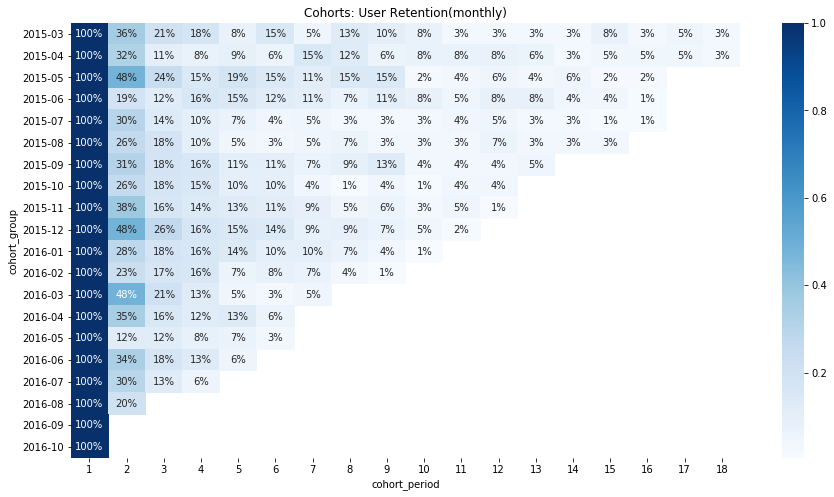

In [39]:
plt.figure(figsize=(15, 8))
plt.title('Cohorts: User Retention(monthly)')
sns.heatmap(retentions.T, mask=retentions.T.isnull(), annot=True, fmt='.0%', cmap="Blues")
plt.savefig('09.png')
plt.show()

# Time in Application

In [40]:
events_4.head()

,user_id,user_session_id,event_timestamp,app,time_min,install_date,app_version,date
0,02fd5305cce536a1940aea0818ba7a3d,6690452e89aa62cdfa818d1f469aaf37,2015-03-22 00:08:12,build,1.116667,2015-03-21,v1,2015-03
1,955ef0ba3e7de00197f2ab6828cb4d05,af2d613e4e5695fd4d8610a0086de760,2015-03-22 20:56:29,build,4.616667,2015-01-26,v1,2015-03
2,955ef0ba3e7de00197f2ab6828cb4d05,af2d613e4e5695fd4d8610a0086de760,2015-03-22 21:15:33,build,12.983333,2015-01-26,v1,2015-03
3,3768b95029f051316727e5413362dcff,7af8b316d551662e89ef0afbedd06be8,2015-03-22 02:17:00,build,2.416667,2015-03-22,v1,2015-03
4,3768b95029f051316727e5413362dcff,7af8b316d551662e89ef0afbedd06be8,2015-03-22 03:26:03,draw,5.316667,2015-03-22,v1,2015-03


In [41]:
session_versions = events_4.groupby(['app_version','user_session_id']).agg({'time_min' : 'sum'})

In [42]:
session_versions = session_versions.reset_index()
session_versions.head(6)

,app_version,user_session_id,time_min
0,v1,000049d4bd64e00280c072f1eca2d105,0.300000
1,v1,001354e84313a35579d47262fd3360c0,15.300000
2,v1,00ab5a9d45b6b2adc4c7838bb7b00fbf,4.100000
3,v1,00fd85e8beda3b77003300f175124cbb,3.150000
4,v1,0120f8d5052eb676662bc84e7d9e545e,30.016667
5,v1,015cfd0bb2234184f4cc17c0634033a2,4.166667


In [43]:
session_versions_2 = session_versions.groupby(['app_version']).agg({'user_session_id':'count','time_min': 'mean'})
session_versions_2

,user_session_id,time_min
app_version,,
v1,1086,26.483441
v2,12558,30.322043
v3,454,33.030140


In [44]:
version_1 = session_versions[session_versions['app_version']=='v1']['time_min']
version_2 = session_versions[session_versions['app_version']=='v2']['time_min']
version_3 = session_versions[session_versions['app_version']=='v3']['time_min']

In [45]:
bins = [-0.1, 1, 5, 10, 30, 60, 480, 1000]

In [46]:
version_1_buckets = pd.cut(version_1, bins=bins)
version_2_buckets = pd.cut(version_2, bins=bins)
version_3_buckets = pd.cut(version_3, bins=bins)

In [47]:
version_1_buckets.value_counts()

(10.0, 30.0]       322
(1.0, 5.0]         200
(30.0, 60.0]       182
(5.0, 10.0]        154
(60.0, 480.0]      144
(-0.1, 1.0]         84
(480.0, 1000.0]      0
Name: time_min, dtype: int64

In [48]:
version_2_buckets.value_counts()

(10.0, 30.0]       3715
(30.0, 60.0]       2275
(1.0, 5.0]         2132
(60.0, 480.0]      1905
(5.0, 10.0]        1580
(-0.1, 1.0]         945
(480.0, 1000.0]       6
Name: time_min, dtype: int64

In [49]:
version_3_buckets.value_counts()

(10.0, 30.0]       137
(60.0, 480.0]       89
(1.0, 5.0]          84
(30.0, 60.0]        64
(5.0, 10.0]         42
(-0.1, 1.0]         38
(480.0, 1000.0]      0
Name: time_min, dtype: int64

# Monthly Session Counts per User

In [50]:
events_4.head(3)

,user_id,user_session_id,event_timestamp,app,time_min,install_date,app_version,date
0,02fd5305cce536a1940aea0818ba7a3d,6690452e89aa62cdfa818d1f469aaf37,2015-03-22 00:08:12,build,1.116667,2015-03-21,v1,2015-03
1,955ef0ba3e7de00197f2ab6828cb4d05,af2d613e4e5695fd4d8610a0086de760,2015-03-22 20:56:29,build,4.616667,2015-01-26,v1,2015-03
2,955ef0ba3e7de00197f2ab6828cb4d05,af2d613e4e5695fd4d8610a0086de760,2015-03-22 21:15:33,build,12.983333,2015-01-26,v1,2015-03


In [51]:
session_versions_3 = events_4.groupby(['app_version','date','user_id']).agg({'user_session_id' : pd.Series.nunique})
session_versions_4 = session_versions_3.groupby(['app_version','date']).agg({'user_session_id' : 'mean'})

In [52]:
session_versions_4.head()

user_session_id
app_version date                    
v1          2015-03         1.538462
            2015-04         1.696203
            2015-05         2.545455
            2015-06         2.222222
            2015-07         2.419355

In [53]:
session_versions_5 = session_versions_4.unstack(level=0)

In [54]:
session_versions_5

user_session_id                    
app_version              v1        v2        v3
date                                           
2015-03            1.538462       NaN       NaN
2015-04            1.696203       NaN       NaN
2015-05            2.545455  2.214286       NaN
2015-06            2.222222  3.474359       NaN
2015-07            2.419355  3.155844       NaN
2015-08            2.363636  3.063291       NaN
2015-09            3.000000  3.240964       NaN
2015-10            2.184211  2.750000       NaN
2015-11            2.548387  3.565217       NaN
2015-12            2.461538  3.227437       NaN
2016-01            2.304348  3.296855       NaN
2016-02            1.357143  2.929293       NaN
2016-03            2.333333  2.829268       NaN
2016-04            1.666667  2.834320  5.000000
2016-05            1.307692  2.758278  4.200000
2016-06            3.333333  2.565000  4.160000
2016-07            2.000000  2.308108  3.593220
2016-08            1.900000  2.044444  2.760000
2016-09            2.111111  2.360465  1.882353
2016-10            2.000000  1.480000  1.200000

In [55]:
session_versions_5.columns = session_versions_5.columns.droplevel(level=0)

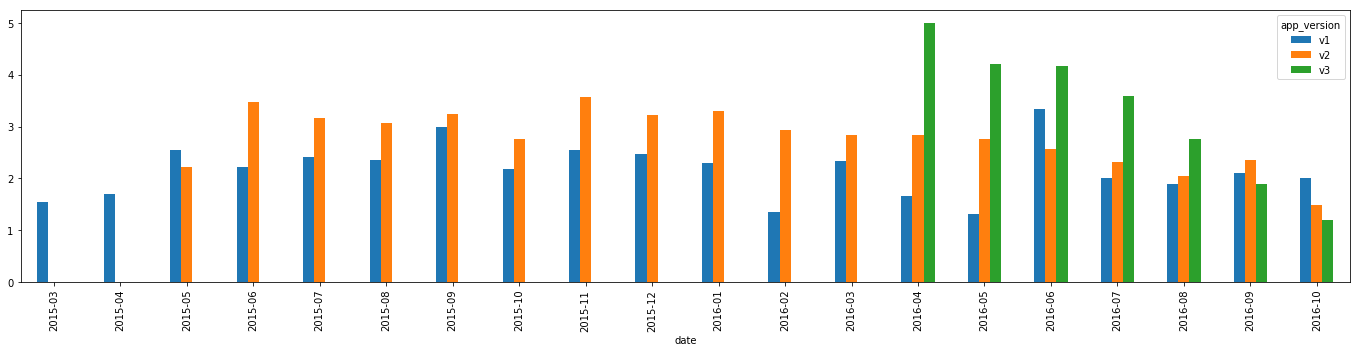

In [56]:
session_versions_5.plot(figsize=(19,5), kind='bar')
plt.tight_layout()
plt.savefig('10.png')
plt.show()

# App Area Counts per Sessions

In [76]:
events_4.head()

,user_id,user_session_id,event_timestamp,app,time_min,install_date,app_version,date
0,02fd5305cce536a1940aea0818ba7a3d,6690452e89aa62cdfa818d1f469aaf37,2015-03-22 00:08:12,build,1.116667,2015-03-21,v1,2015-03
1,955ef0ba3e7de00197f2ab6828cb4d05,af2d613e4e5695fd4d8610a0086de760,2015-03-22 20:56:29,build,4.616667,2015-01-26,v1,2015-03
2,955ef0ba3e7de00197f2ab6828cb4d05,af2d613e4e5695fd4d8610a0086de760,2015-03-22 21:15:33,build,12.983333,2015-01-26,v1,2015-03
3,3768b95029f051316727e5413362dcff,7af8b316d551662e89ef0afbedd06be8,2015-03-22 02:17:00,build,2.416667,2015-03-22,v1,2015-03
4,3768b95029f051316727e5413362dcff,7af8b316d551662e89ef0afbedd06be8,2015-03-22 03:26:03,draw,5.316667,2015-03-22,v1,2015-03


In [77]:
area_1 = events_4.groupby(['app_version','date','user_session_id']).agg({'app' : pd.Series.nunique})

In [78]:
area_2 = area_1.groupby(['app_version','date']).agg({'app' : 'mean'})

In [79]:
area_3 = area_2.unstack(level=0)

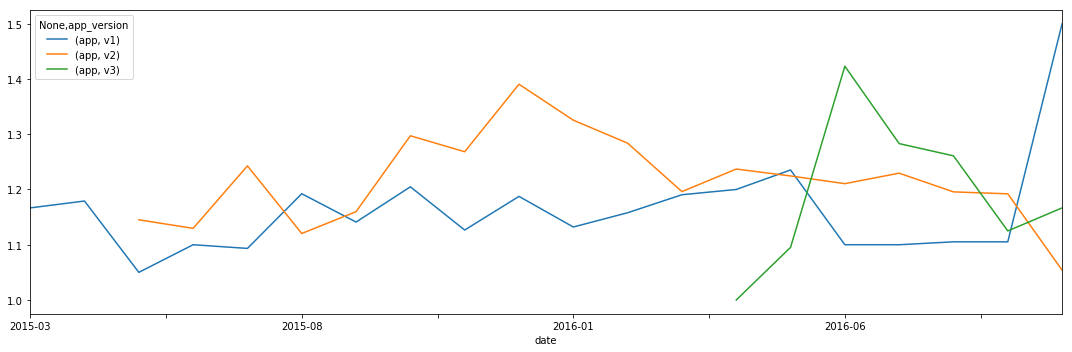

In [80]:
area_3.plot(figsize=(15,5))
plt.tight_layout()
plt.savefig('11.png')
plt.show()